# Wildfire Location Analysis in Canada

**Objective:** This notebook processes wildfire geospatial data to identify the Canadian province for each fire location.

**Steps:**
1. **Data Loading:** Import raw wildfire coordinates and Canadian provincial boundaries.
2. **Geospatial Processing:** Convert coordinates into geometric points and map them to provinces using a spatial join.
3. **Analysis:** Summarize the number of fires per province.
4. **Visualization:** Plot the wildfire locations on a map distinguished by province.

## 1. Environment Setup
Installing necessary libraries for reverse geocoding and importing standard data science and geospatial tools (`pandas`, `geopandas`, `matplotlib`).

In [ ]:
!pip install reverse_geocoder

In [ ]:
import pandas as pd
import geopandas as gdp
import matplotlib.pyplot as plt
import reverse_geocoder as rg
import folium
from folium.plugins import HeatMap
import plotly.express as px

## 2. Data Loading
We load the raw wildfire dataset containing coordinate information (`X`, `Y`) and the GeoJSON file representing Canadian provincial boundaries.

In [ ]:
input_csv = 'https://github.com/LamaEmran/Data/raw/main/long.lat.csv'
output_csv = 'wildfire_points_with_provinces.csv'

In [ ]:
input = pd.read_csv(input_csv)

## 3. Geospatial Conversion
To perform spatial operations, we first standardize column names to `longitude` and `latitude`. Then, we convert the pandas DataFrame into a `GeoDataFrame`, defining the geometry using the standard WGS84 coordinate reference system (EPSG:4326).

In [ ]:
if 'X' in input.columns and 'Y' in input.columns:
  input = input.rename(columns = {'X': 'longitude', 'Y': 'latitude'})

In [ ]:
# Turning these coordinates into a Geospatial Data Frame (points)
gdf_points = gdp.GeoDataFrame(input,
                              geometry = gdp.points_from_xy(input.longitude, input.latitude),
                              crs = "EPSG:4326") #crs = "EPSG:4326" tells gdp that these coordinates are lat & long on the Earth using standard GPS

## 4. Province Mapping (Spatial Join)
We load the official Canadian province boundaries and perform a **Spatial Join** with the wildfire points. This effectively "tags" each fire with the name of the province it falls within.

In [ ]:
# The official geographic boundaries of all Canadian provinces and territories
provinces_url = "https://raw.githubusercontent.com/codeforgermany/click_that_hood/main/public/data/canada.geojson"
provinces = gdp.read_file(provinces_url)

This link provides a GeoJSON map file that contains the official boundaties of all Canadian provinces, which we use to match each wildfire point to its correct province.

In [ ]:
spatial_join = gdp.sjoin(gdf_points, provinces, how = 'left', predicate = 'within')

if 'name' in spatial_join.columns:
  spatial_join = spatial_join.rename(columns = {'name': 'Province'})

output_cols = ['longitude', 'latitude', 'Province']
final_df = spatial_join[output_cols]
final_df.to_csv(output_csv, index = False)

In this step, we took the wildfire coordinate data (latitude & longtitude) and used Canadian province boundary maps to detemine which province each point belongs to. This was done using spatial joints in GeoPandas.

The output is a new CSV file where every wildfire record now includes its corresponding **Province**, making the data easier to analyze and visualize by region.

In [ ]:
final_df.head()

,longitude,latitude,Province
0,-88.0381,49.0228,Ontario
1,-86.7287,49.8475,Ontario
2,-88.0725,50.2296,Ontario
3,-88.5994,53.4975,Ontario
4,-87.9607,50.2486,Ontario


## 5. Statistical Summary
We group the data by the newly assigned `Province` column to see the distribution of wildfires. As expected for this dataset, the vast majority should align with Ontario.

In [ ]:
final_df['Province'].value_counts()

,count
Province,
Ontario,63942
Quebec,29
Manitoba,19


After assigning each wildfire point to its corresponding province, the results show that almost all records (63,942 points) fall within Ontario. This is expected because the original dataset is an official Ontario Fire Disturbance dataset.

A small number of points were assigned to Quebec (29) and Manitoba (19). These likely occur due to fires located near provincial borders, minor coordinate inaccuracies, or boundary alignment effects during the spatial join. Overall, the results confirm that the province assignment process worked correctly and that the dataset is heavily concentrated in Ontario, as expected.

## 6. Visualization
Finally, we visualize the spatial distribution of the fires.
* **Red:** Ontario (Primary focus)
* **Black:** Outlying points (Quebec/Manitoba)
* **Grey:** Provincial boundaries

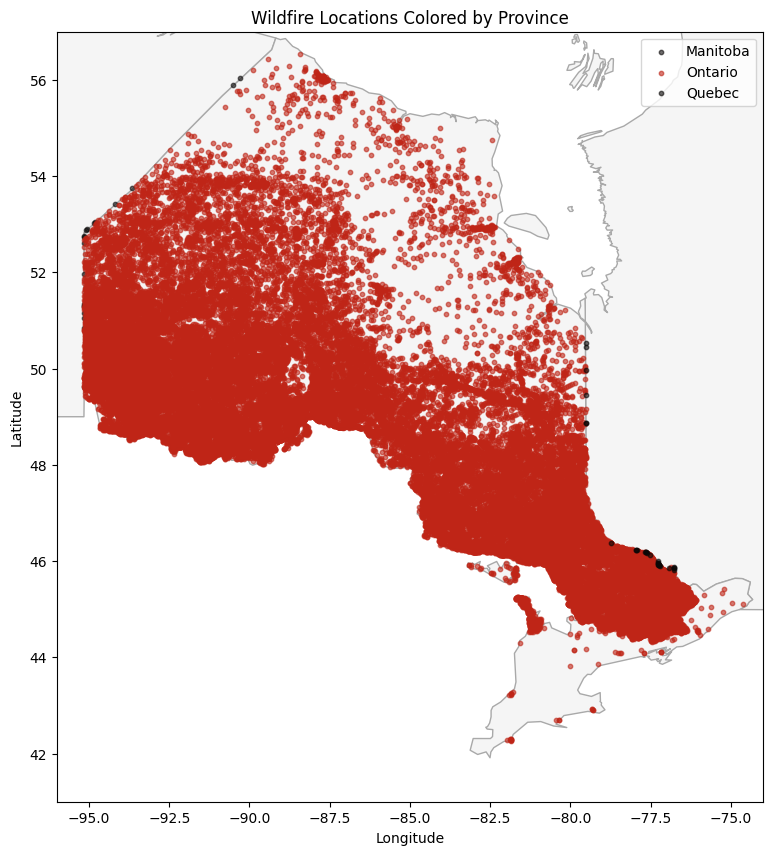

In [ ]:
colors = {
    'Ontario': '#bf2517',
    'Quebec': '#0a0807',
    'Manitoba': '#0d0b0b'}

fig, ax = plt.subplots(figsize = (15, 10))
provinces.plot(ax = ax, color = 'whitesmoke', edgecolor = 'darkgrey')
for province_name, data in spatial_join.groupby('Province'):

    assigned_color = colors.get(province_name, 'black')

    data.plot(
        ax = ax,
        color = assigned_color,
        label = province_name,
        markersize = 10,
        alpha = 0.6
    )

plt.title('Wildfire Locations Colored by Province')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.xlim(-96, -74)
plt.ylim(41, 57)

plt.show()

In [ ]:
inputt_csv = 'https://github.com/LamaEmran/Data/raw/main/wildfire_points_with_provinces.csv'
outputt_csv = 'wildfire_points_with_cities.csv'

In [ ]:
dff = pd.read_csv(inputt_csv)
coords = list(zip(dff['latitude'], dff['longitude']))

In [ ]:
results = rg.search(coords)
dff['City / Town'] = [r['name'] for r in results]
dff.to_csv(outputt_csv, index = False)

The next step in the workflow is to enrich the wildfire dataset by adding the nearest city for each point using reverse geocoding. This builds on the previuos output that already contains the province, producing a richer dataset with both regional (Province: polygon-based -- very precise) and local (City/Town: distance-based -- nearest town) location information.

In [ ]:
dff.head()

,longitude,latitude,Province,City / Town
0,-88.0381,49.0228,Ontario,Greenstone
1,-86.7287,49.8475,Ontario,Greenstone
2,-88.0725,50.2296,Ontario,Greenstone
3,-88.5994,53.4975,Ontario,Greenstone
4,-87.9607,50.2486,Ontario,Greenstone


In [ ]:
dff['City / Town'].value_counts()

,count
City / Town,
Greenstone,5189
Red Lake,4854
Greater Sudbury,4316
Atikokan,4229
Ear Falls,3772
...,...
Wingham,1
Prescott,1
Keswick,1


In [ ]:
city_counts = dff.groupby(['Province', 'City / Town']).size().reset_index(name='Fire_Count')
city_counts = city_counts.sort_values(by='Fire_Count', ascending=False)
print(city_counts.head(20))

   Province         City / Town  Fire_Count
32  Ontario          Greenstone        5130
72  Ontario            Red Lake        4839
6   Ontario            Atikokan        4229
31  Ontario     Greater Sudbury        4216
20  Ontario           Ear Falls        3772
19  Ontario              Dryden        3601
84  Ontario         Thunder Bay        3403
34  Ontario          Hornepayne        1801
9   Ontario            Baudette        1744
7   Ontario            Bancroft        1536
21  Ontario         Elliot Lake        1530
58  Ontario         Parry Sound        1511
85  Ontario             Timmins        1425
71  Ontario     Rayside-Balfour        1413
76  Ontario    Sault Ste. Marie        1392
46  Ontario            Marathon        1168
53  Ontario           North Bay        1115
38  Ontario         Kapuskasing        1109
33  Ontario              Hearst        1077
82  Ontario  Temiskaming Shores         978


In [ ]:
ontario_data = city_counts[city_counts['Province'] == 'Ontario']
total_cities = ontario_data.shape[0]
ontario_data.head()

,Province,City / Town,Fire_Count
32,Ontario,Greenstone,5130
72,Ontario,Red Lake,4839
6,Ontario,Atikokan,4229
31,Ontario,Greater Sudbury,4216
20,Ontario,Ear Falls,3772


In [ ]:
manitoba_data = city_counts[city_counts['Province'] == 'Manitoba']
total_cities = manitoba_data.shape[0]
manitoba_data.head()

,Province,City / Town,Fire_Count
1,Manitoba,Red Lake,15
0,Manitoba,Lac du Bonnet,3
2,Manitoba,Warroad,1


In [ ]:
quebec_data = city_counts[city_counts['Province'] == 'Quebec']
total_cities = quebec_data.shape[0]
quebec_data.head()

,Province,City / Town,Fire_Count
96,Quebec,Petawawa,9
92,Quebec,Deep River,8
94,Quebec,La Sarre,6
93,Quebec,Fort-Coulonge,5
95,Quebec,Mattawa,1


In [ ]:
m = folium.Map(location = [50.0, - 85.0], zoom_start = 5)
heat_data = dff[['latitude', 'longitude']].values.tolist()
HeatMap(heat_data, radius = 10, blur = 15, max_zoom = 10).add_to(m)

m

In [ ]:
city_coords = dff.groupby('City / Town')[['latitude', 'longitude']].mean().reset_index()
bubble_data = pd.merge(city_counts, city_coords, on='City / Town')

fig = px.scatter_mapbox(
    bubble_data,
    lat = 'latitude',
    lon = 'longitude',
    size = 'Fire_Count',
    color = 'Fire_Count',
    hover_name = 'City / Town',
    hover_data = ['Province', 'Fire_Count'],
    color_continuous_scale = px.colors.cyclical.IceFire,
    size_max = 50,
    zoom = 3.5,
    mapbox_style = 'carto-positron',
    title = 'Wildfire Frequency by Nearest Town'
)

fig.show()

In [ ]:
inputtt_csv = 'https://github.com/LamaEmran/Data/raw/main/ontario_wildfires.csv'
outputtt_csv = 'ontario_wildfires.csv'

In [ ]:
dfff = pd.read_csv(inputtt_csv)

In [ ]:
ontario = dfff[dfff['Province'] == 'Ontario'].copy()
ontario.head()

,longitude,latitude,Province,City / Town
0,-88.0381,49.0228,Ontario,Greenstone
1,-86.7287,49.8475,Ontario,Greenstone
2,-88.0725,50.2296,Ontario,Greenstone
3,-88.5994,53.4975,Ontario,Greenstone
4,-87.9607,50.2486,Ontario,Greenstone


In [ ]:
ontario_wildfires['Province'].value_counts()

,count
Province,
Ontario,63942


In [ ]:
ontario['City / Town'].value_counts()

,count
City / Town,
Greenstone,5130
Red Lake,4839
Atikokan,4229
Greater Sudbury,4216
Ear Falls,3772
...,...
Massena,1
Prescott,1
Keswick,1


In [ ]:
ontario['City / Town'].unique()

array(['Greenstone', 'Marathon', 'Hornepayne', 'Thunder Bay',
       'Parry Sound', 'Mattawa', 'Greater Sudbury', 'North Bay',
       'Temiskaming Shores', 'South River', 'Ville-Marie', 'Powassan',
       'Temiscaming', 'Gravenhurst', 'Midland', 'Bracebridge',
       'Deep River', 'Renfrew', 'Skatepark', 'Red Lake', 'Ear Falls',
       'Sault Ste. Marie', 'Thessalon', 'Elliot Lake', 'Atikokan',
       'Dryden', 'Huntsville', 'Bancroft', 'Greater Napanee', 'Omemee',
       'Kapuskasing', 'Iroquois Falls', 'Timmins', 'Baudette',
       'International Falls', 'Fort Frances', 'Ely', 'Hearst', 'Arnprior',
       'Warroad', 'Lac du Bonnet', 'Englehart', 'Kirkland Lake', 'Barrie',
       'Neebing', 'Grand Marais', 'Rayside-Balfour', 'La Sarre',
       'Carleton Place', 'Petawawa', 'Fort-Coulonge', 'Kingston',
       'Espanola', 'Wasaga Beach', 'Little Current', 'Peterborough',
       'Perth', 'Pembroke', 'Belleville', 'Orangeville', 'Petrolia',
       'Quinte West', 'Orillia', 'Norfolk County

In [ ]:
ontario.to_csv(outputtt_csv, index = False)

- **Province**: Each wildfire point is assigned to a Canadian province using a **precise spatial join** with official boundary polygons, ensuring accurate regional classification.

- **City**: The nearest city is determined via **reverse geocoding**, which finds the closest recognized population center to each coordinate.

Because of northen and border regions are sparsely populated, some points witin Ontario are assigned a nearest city located in neighboring provinces (e.g., Quebec: Ville-Marie, La Sarre, and Manitoba: Lac du Bonnet) or even the USA (e.g., International Falls, Alexandria Bay, Grand Marais,..). This is expected behavior and reflects the difference between polygon-based Province assignment and distance-based City lookup.

In [ ]:
Linput_csv = 'https://github.com/LamaEmran/Data/raw/main/ontario_wildfires%20(1).csv'
Loutputtt_csv = 'ontario_wildfires_refined.csv'

In [ ]:
wildfires = pd.read_csv(Linput_csv)
cities_to_drop = [
    'Temiscaming', 'Baudette', 'International Falls',
    'Ely', 'Warroad', 'Fort-Coulonge', 'Rouyn-Noranda', 'Shawville',
    'Alexandria Bay', 'Saint-Bruno-de-Guigues', 'Massena', 'Rankin Inlet', 'Ville-Marie', 'La Sarre', 'Lac du Bonnet',
    'Grand Marais']

In [ ]:
city_col = 'City / Town' if 'City / Town' in wildfires.columns else 'city/name'
ontario_wildfires_refined = wildfires[~wildfires[city_col].isin(cities_to_drop)].copy()

In [ ]:
print("Original Row Count", len(wildfires))
print("Filtered Row Count", len(ontario_wildfires_refined))

Original Row Count 63942
Filtered Row Count 58265


In [ ]:
ontario_wildfires_refined['City / Town'].unique()

array(['Greenstone', 'Marathon', 'Hornepayne', 'Thunder Bay',
       'Parry Sound', 'Mattawa', 'Greater Sudbury', 'North Bay',
       'Temiskaming Shores', 'South River', 'Powassan', 'Gravenhurst',
       'Midland', 'Bracebridge', 'Deep River', 'Renfrew', 'Skatepark',
       'Red Lake', 'Ear Falls', 'Sault Ste. Marie', 'Thessalon',
       'Elliot Lake', 'Atikokan', 'Dryden', 'Huntsville', 'Bancroft',
       'Greater Napanee', 'Omemee', 'Kapuskasing', 'Iroquois Falls',
       'Timmins', 'Fort Frances', 'Hearst', 'Arnprior', 'Englehart',
       'Kirkland Lake', 'Barrie', 'Neebing', 'Rayside-Balfour',
       'Carleton Place', 'Petawawa', 'Kingston', 'Espanola',
       'Wasaga Beach', 'Little Current', 'Peterborough', 'Perth',
       'Pembroke', 'Belleville', 'Orangeville', 'Petrolia', 'Quinte West',
       'Orillia', 'Norfolk County', 'Tobermory', 'Norfolk',
       'Port Colborne', 'Lambton Shores', 'Owen Sound', 'Deseronto',
       'Gananoque', 'Picton', 'Smiths Falls', 'Bourget', 'Cornw

In [ ]:
ontario_wildfires_refined.to_csv('ontario_wildfires_refined.csv', index = False)

To ensure the dataset accuratly represents wildfire events within Ontario, a manual verefication of the City / Town column was conducted. All cities located outside Ontario (including points near provincial borders or in neighboring provinces and the USA) were identified and removed. This careful refinement, saved as ontario_wildfires_refined.csv, guarantees that both Province and City / Town columns are geographically consistent. By combining precise polygon-based province assignment with validatet city-level information.

In [ ]:
m = folium.Map(location = [50.0, - 85.0], zoom_start = 5)
heat_data = ontario_wildfires_refined[['latitude', 'longitude']].values.tolist()
HeatMap(heat_data, radius = 10, blur = 15, max_zoom = 10).add_to(m)

m

In [ ]:
ontario_wildfires = dff[dff['Province'] == 'Ontario'].copy()
gdf_ontario = gdp.GeoDataFrame(
    ontario_wildfires,
    geometry=gdp.points_from_xy(ontario_wildfires.longitude, ontario_wildfires.latitude),
    crs="EPSG:4326"
)

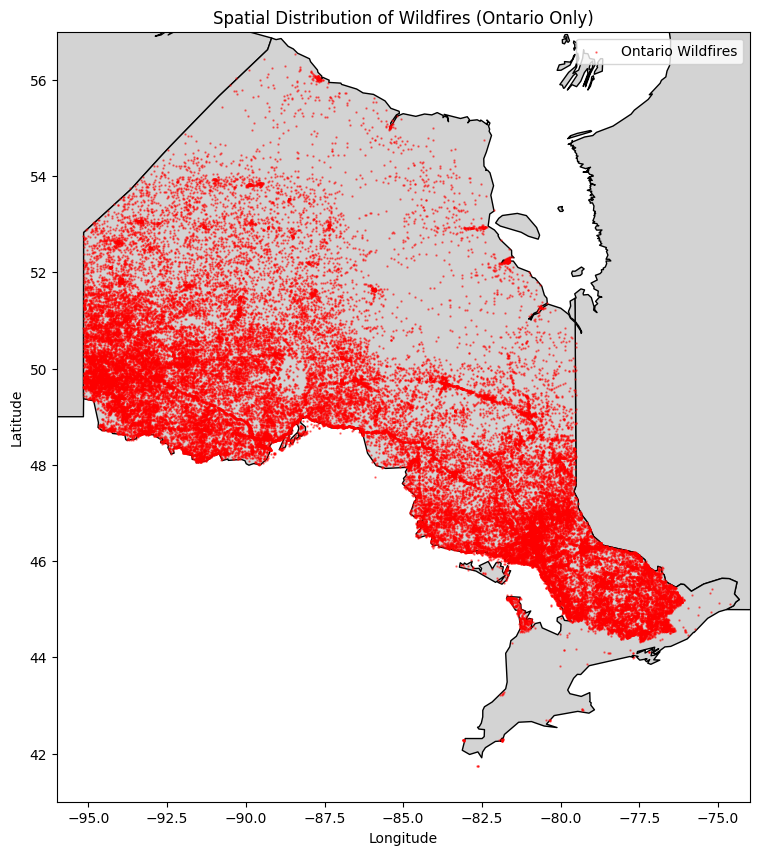

In [ ]:
fig, ax = plt.subplots(figsize = (15, 10))

provinces.plot(ax = ax, color = 'lightgrey', edgecolor = 'black')
gdf_points.plot (ax = ax, color = 'red', markersize = 0.5, alpha = 0.5, label ='Ontario Wildfires')

plt.title('Spatial Distribution of Wildfires (Ontario Only)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.xlim(-96, -74)
plt.ylim(41, 57)
plt.show()


### Conclusion
The spatial analysis confirms that the dataset is highly localized to Ontario, with over 99% of points falling within its boundaries. Minor outliers in Quebec and Manitoba may represent border fires or slight coordinate deviations.